Outline based on Jose Celis' "lstm-val_v2.ipynb"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np, pandas as pd
from black_scholes import BlackScholesModel


In [4]:
import matplotlib.pyplot as plt

def plotprices(pred_df):
  plt.figure(figsize=(12, 6))

  # Plot predictions (yhat)
  plt.plot(pred_df["valuation_date"], pred_df["yhat"], label="Predicted (yhat)", linewidth=2)

  # Plot true values (y_true)
  plt.plot(pred_df["valuation_date"], pred_df["y_true"], label="Actual (y_true)", linewidth=2)

  # Formatting
  plt.xlabel("Valuation Date")
  plt.ylabel("Option Price")
  plt.title("Predicted vs Actual Option Prices Over Time")
  plt.legend()
  plt.grid(True)

  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [25]:
#df = pd.read_csv("../data/data.csv", nrows=1000000, low_memory=False, index_col=0)


# use_cols = ["QUOTE_DATE", "UNDERLYING_LAST", "STRIKE", "EXPIRE_DATE", "C_BID", "VOL_GG", "RFR", "DTE"]
use_cols = ["QUOTE_DATE", "EXPIRE_DATE", "STRIKE", "UNDERLYING_LAST", "DTE", "VOL_90D", "VOL_GG", "RFR", "C_BID", "C_ASK"]
# BS needs current_price, exercise_price, time_to_maturity (years), volatility, and risk_free_rate

chunks = []

for chunk in pd.read_csv("data/data.csv", chunksize=200_000, usecols=use_cols, low_memory=False):
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])

df.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_BID,C_ASK,STRIKE,RFR,VOL_90D,VOL_GG
0,2022-04-01,4545.81,2022-04-01,0.0,3736.20,3754.50,800.0,0.15,0.258858,0.240809
1,2022-04-01,4545.81,2022-07-15,105.0,1.45,1.60,5375.0,0.53,0.258858,0.240809
2,2022-04-01,4545.81,2022-07-15,105.0,1.65,1.85,5350.0,0.53,0.258858,0.240809
3,2022-04-01,4545.81,2022-07-15,105.0,1.85,2.05,5325.0,0.53,0.258858,0.240809
4,2022-04-01,4545.81,2022-07-15,105.0,2.05,2.35,5300.0,0.53,0.258858,0.240809


In [6]:
df[["STRIKE", "EXPIRE_DATE"]].drop_duplicates().shape[0]

90922

In [7]:
# subset = df[['QUOTE_DATE',
# 'UNDERLYING_LAST',
# 'EXPIRE_DATE',
# 'DTE','MTM',
# '1 Mo',
# '2 Mo',
# '3 Mo',
# '4 Mo',
# '6 Mo',
# '1 Yr',
# '2 Yr',
# '3 Yr',
# 'RFR',
# 'VOL_90D',
# 'VOL_GG','C_BID',
# 'C_ASK',
# 'STRIKE',
# 'P_BID',
# 'P_ASK',]]


# subset_800 = subset[((subset["STRIKE"] == 2740) | (subset["STRIKE"] == 4825.0) | (subset["STRIKE"] == 5375.0) | (subset["STRIKE"] == 800.0)) & (subset["EXPIRE_DATE"] == "2023-03-17")]

#subset_800 = subset[((subset["STRIKE"] == 4825.0) | (subset["STRIKE"] == 800.0)) & (subset["EXPIRE_DATE"] == "2023-03-17")]

subset_800 = df[((df["STRIKE"] == 2740) | (df["STRIKE"] == 4825.0) | (df["STRIKE"] == 5375.0) | (df["STRIKE"] == 800.0)) & (df["EXPIRE_DATE"] == "2023-03-17") & (df["QUOTE_DATE"] < "2023-01-01")]

subset_800_test = df[((df["STRIKE"] == 2740) | (df["STRIKE"] == 4825.0) | (df["STRIKE"] == 5375.0) | (df["STRIKE"] == 800.0)) & (df["EXPIRE_DATE"] == "2023-03-17") & (df["QUOTE_DATE"] >= "2023-01-01")]

subset_800 = subset_800.sort_values(by=["QUOTE_DATE", "STRIKE"])
subset_800.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_BID,STRIKE,RFR,VOL_GG
2362,2022-04-01,4545.81,2023-03-17,350.0,3700.7,800.0,1.683311,0.240809
2330,2022-04-01,4545.81,2023-03-17,350.0,221.5,4825.0,1.683311,0.240809
2007,2022-04-01,4545.81,2023-03-17,350.0,49.6,5375.0,1.683311,0.240809
9959,2022-04-04,4582.84,2023-03-17,347.0,3738.3,800.0,1.678717,0.236382
9926,2022-04-04,4582.84,2023-03-17,347.0,235.9,4825.0,1.678717,0.236382


In [8]:
subset_800.shape

(576, 8)

In [9]:
subset_800_test.shape

(153, 8)

# Black Scholes Predictions

In [15]:
bs_model = BlackScholesModel()

In [31]:
# Just add the black scholes prediction to the df at each row. For BS I just need current_price, exercise_price, time_to_maturity (years), volatility, and risk_free_rate

# use_cols = ["QUOTE_DATE", "EXPIRE_DATE", "STRIKE", "UNDERLYING_LAST", "DTE", "VOL_90D", "VOL_GG", "RFR", "C_BID"]

# Change time to years
df["T_TO_EXPIRY_YEARS"] = df["DTE"] / 365.25

# I believe I change the RFR to a number, not a percentage
df["RFR_NUM"] = df["RFR"] / 100

df["BS_PRICE"] = bs_model.predicted_call_price_vectorized(
    current_price=df["UNDERLYING_LAST"].to_numpy(),
    exercise_price=df["STRIKE"].to_numpy(),
    time_to_maturity=df["T_TO_EXPIRY_YEARS"].to_numpy(),
    volatility=df["VOL_90D"].to_numpy(),
    risk_free_rate=df["RFR_NUM"].to_numpy()
)

# Adding BS_PRICE_GG
df["BS_PRICE_GG"] = bs_model.predicted_call_price_vectorized(
    current_price=df["UNDERLYING_LAST"].to_numpy(),
    exercise_price=df["STRIKE"].to_numpy(),
    time_to_maturity=df["T_TO_EXPIRY_YEARS"].to_numpy(),
    volatility=df["VOL_GG"].to_numpy(),
    risk_free_rate=df["RFR_NUM"].to_numpy()
)

# Heston Predictions

In [ ]:
# I'm going to need to figure out the exact inputs to heston and vectorize my heston implementation

## RMSE by Time to Maturity (Figure 9)

In [42]:
# I now have the BS predicted prices (under regular volatility)
# Now I want to get the RMSE of the predictions

# Going to test against the average of C_BID and C_ASK for the "actual" price to do RMSE against

df["ACTUAL_PRICE"] = (df["C_BID"] + df["C_ASK"]) / 2

# Get binned RMSE based on time to maturity
# Reproduce figure 9 by graphing RMSE vs time to maturity (days)
# In the paper they bin the x axis between 1-90 days, 91-180, etc

dte_bins = [0, 90, 180, 270, 450, 630, 1085]
dte_labels = ["1-90", "91-180", "181-270", "271-450", "451-630", "631-1085"]

df["MATURITY_BIN"] = pd.cut(df["DTE"], bins=dte_bins, labels=dte_labels, right=True)

def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

# Compute the per bin RMSE
bs_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
bs_gg_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["BS_PRICE_GG"], x["ACTUAL_PRICE"]))


print(bs_rmse_per_dte_bin)
print(bs_gg_rmse_per_dte_bin)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_35520\2164429835.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bs_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))


MATURITY_BIN
1-90         11.686129
91-180       25.717006
181-270      34.637461
271-450      47.512922
451-630      66.708651
631-1085    121.249284
dtype: float64
MATURITY_BIN
1-90          0.000000
91-180       24.719346
181-270      32.760393
271-450      47.320318
451-630      72.829823
631-1085    119.303396
dtype: float64


C:\Users\Benjamin\AppData\Local\Temp\ipykernel_35520\2164429835.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bs_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_35520\2164429835.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bs_gg_rmse_per_dte_bin = df.groupby("MATURITY_BIN").apply(lambda x: rmse(x["BS_PRICE_GG"], x["ACTUAL_PRICE"]))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_35520\2164429835.py:2

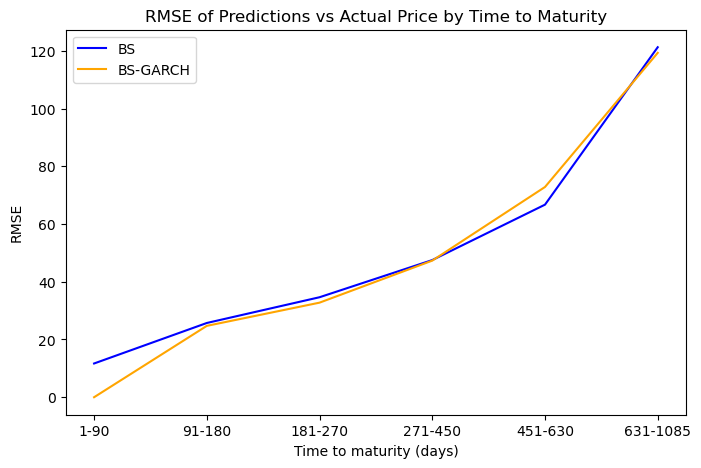

In [ ]:
# Recreate figure 9 by plotting RMSE per dte bin

plt.figure(figsize=(8, 5))
plt.plot(bs_rmse_per_dte_bin.index, bs_rmse_per_dte_bin.values, linestyle="-", color="blue", label="BS")
plt.plot(bs_gg_rmse_per_dte_bin.index, bs_gg_rmse_per_dte_bin.values, linestyle="-", color="orange", label="BS-GARCH")

plt.xlabel("Time to maturity (days)")
plt.ylabel("RMSE")
plt.title("RMSE of Predictions vs Actual Price by Time to Maturity")
plt.legend()
plt.show()

## RMSE by Moneyness (Figure 10)

In [53]:
# Now I'm going to work on recreating figure 10, RMSE of predictions sorted by moneyness

# Moneyness = S_0 / K, or Underlying_Last / Strike_Price
df["MONEYNESS"] = df["UNDERLYING_LAST"] / df["STRIKE"]

moneyness_bins = [0.5, 0.6, 0.7, 0.95, 1.05, 1.15, 1.5, 4.0, 8.0, 42.0]
moneyness_labels = ["0.5-0.6", "0.6-0.7", "0.7-0.95", "0.95-1.05", "1.05-1.15", "1.15-1.5", "1.5-4.0", "4.0-8.0", "8.0-42.0"]

df["MONEYNESS_BIN"] = pd.cut(df["MONEYNESS"], bins=moneyness_bins, labels=moneyness_labels, right=True)

def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

# Compute the per bin RMSE
bs_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
bs_gg_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["BS_PRICE_GG"], x["ACTUAL_PRICE"]))


print(bs_rmse_per_moneyness_bin)
print(bs_gg_rmse_per_moneyness_bin)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_35520\2549299615.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bs_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_35520\2549299615.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bs_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["BS_PRICE"], x["ACTUAL_PRICE"]))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_35520\2549299

MONEYNESS_BIN
0.5-0.6      22.365458
0.6-0.7      32.855292
0.7-0.95     39.249753
0.95-1.05    23.357562
1.05-1.15    16.516680
1.15-1.5     12.626854
1.5-4.0      32.640581
4.0-8.0      76.345684
8.0-42.0     95.554185
dtype: float64
MONEYNESS_BIN
0.5-0.6      23.243702
0.6-0.7      32.142992
0.7-0.95     36.684520
0.95-1.05    21.085262
1.05-1.15    19.588018
1.15-1.5     14.569072
1.5-4.0      32.629690
4.0-8.0      76.346173
8.0-42.0     95.554186
dtype: float64


C:\Users\Benjamin\AppData\Local\Temp\ipykernel_35520\2549299615.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bs_gg_rmse_per_moneyness_bin = df.groupby("MONEYNESS_BIN").apply(lambda x: rmse(x["BS_PRICE_GG"], x["ACTUAL_PRICE"]))


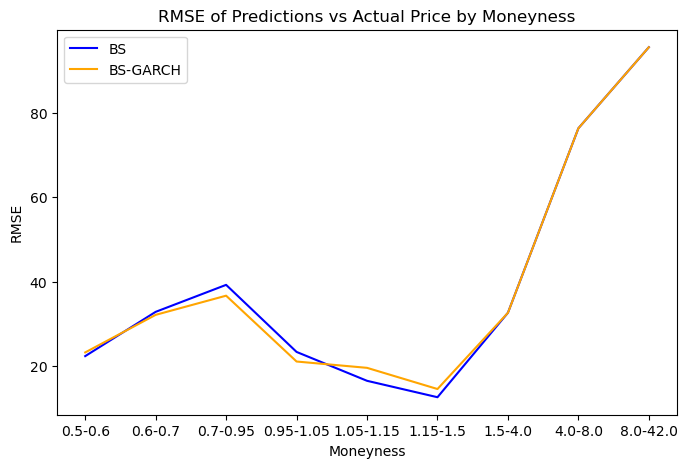

In [54]:
# Recreate figure 10 by plotting RMSE per moneyness bin

plt.figure(figsize=(8, 5))
plt.plot(bs_rmse_per_moneyness_bin.index, bs_rmse_per_moneyness_bin.values, linestyle="-", color="blue", label="BS")
plt.plot(bs_gg_rmse_per_moneyness_bin.index, bs_gg_rmse_per_moneyness_bin.values, linestyle="-", color="orange", label="BS-GARCH")

plt.xlabel("Moneyness")
plt.ylabel("RMSE")
plt.title("RMSE of Predictions vs Actual Price by Moneyness")
plt.legend()
plt.show()

In [12]:
results = []
mse_strike = []

full_pred_df = pd.DataFrame()

for (strike, expiry), group in subset_800.groupby(["STRIKE", "EXPIRE_DATE"]):
    group = group.sort_values("QUOTE_DATE")

    #print(group.shape)
    #print(group)

    pred_df = pd.DataFrame()

    

    # mse, pred_df = train_and_predict(
    #     group,
    #     model,
    #     date_col="QUOTE_DATE",
    #     features=["UNDERLYING_LAST", "STRIKE", "VOL_GG", "RFR", "DTE"],
    #     target_col="C_BID",     # ensure this exists for MSE
    #     type_col="call",        # e.g., "call"/"put"
    #     seq_len=5,
    #     batch_size=16,
    #     epochs=5,
    #     lr = 1e-3,
    #     weight_decay = 3e-4,
    #     grad_clip = 1.0,
    #     device = "cuda",
    #     verbose = True #False
    # )
    #print(pred_df.shape)

    ##pred_df["STRIKE"] = strike
    ##pred_df["EXPIRE_DATE"] = expiry
    print(strike)
    results.append(pred_df)
    mse_strike.append((strike, mse))

full_pred_df = pd.concat(results, ignore_index=True)
full_pred_df.head()

800.0


NameError: name 'mse' is not defined

In [188]:
mse_strike

[(800.0, 11726.779296875),
 (4825.0, 367.7511291503906),
 (5375.0, 8.412179946899414)]

In [189]:
full_pred_df["STRIKE"].unique()

array([ 800., 4825., 5375.], dtype=float32)

In [190]:
full_pred_df.shape

(564, 6)

In [191]:
pred_df_k2 = full_pred_df[full_pred_df["STRIKE"] == 800.0]
pred_df_k4 = full_pred_df[full_pred_df["STRIKE"] == 4825.0]
pred_df_k1 = full_pred_df[full_pred_df["STRIKE"] == 5375.0]

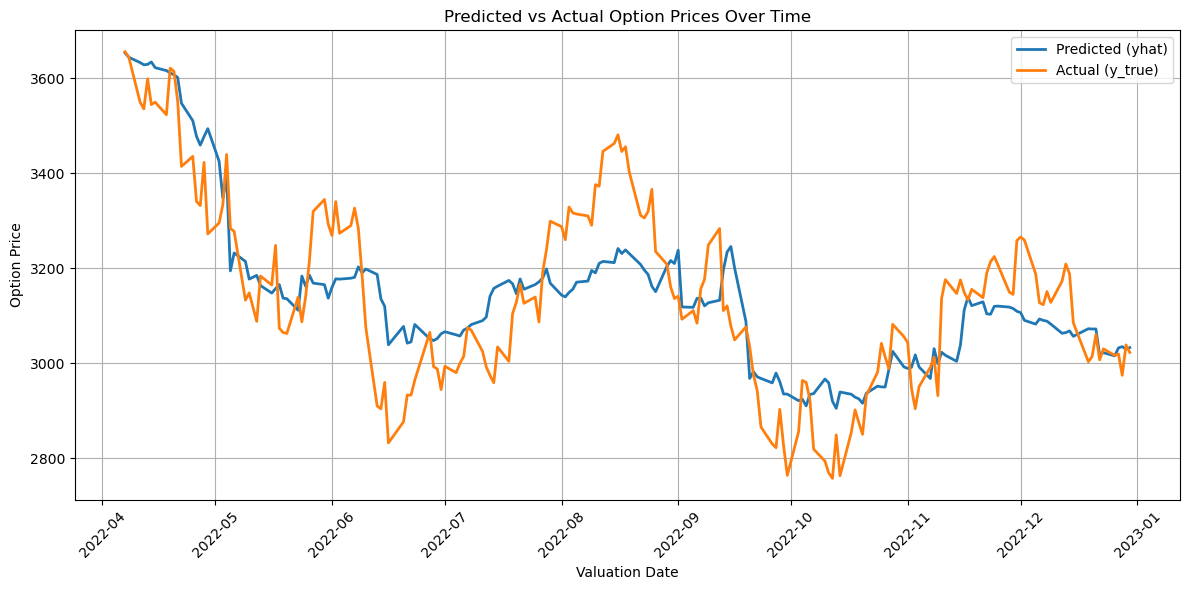

In [192]:
plotprices(pred_df_k2)

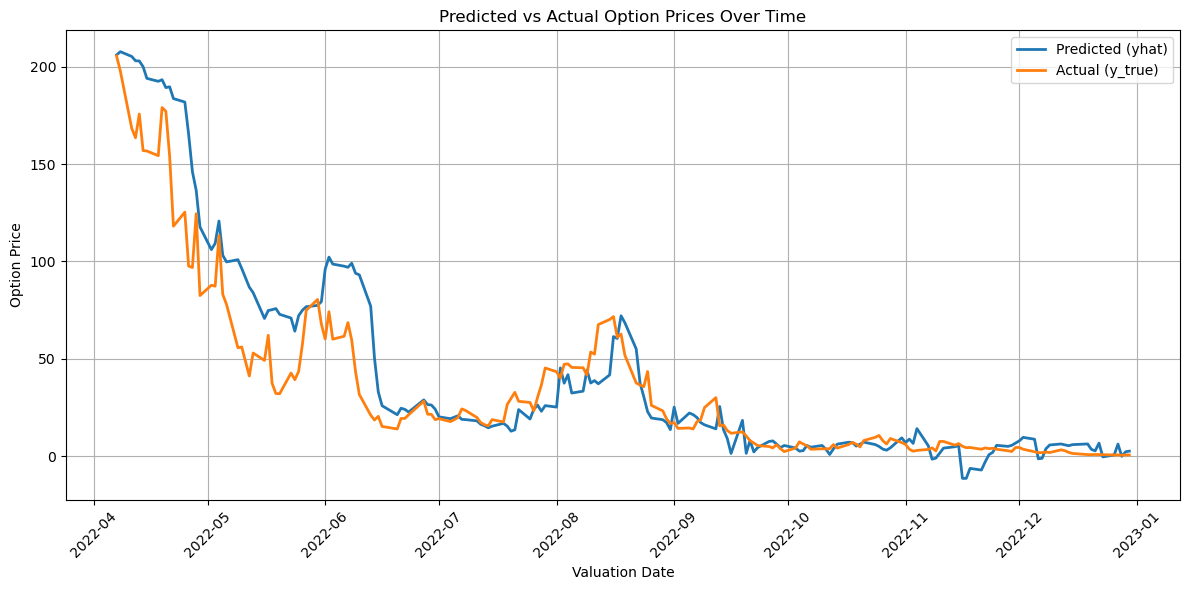

In [193]:
plotprices(pred_df_k4)

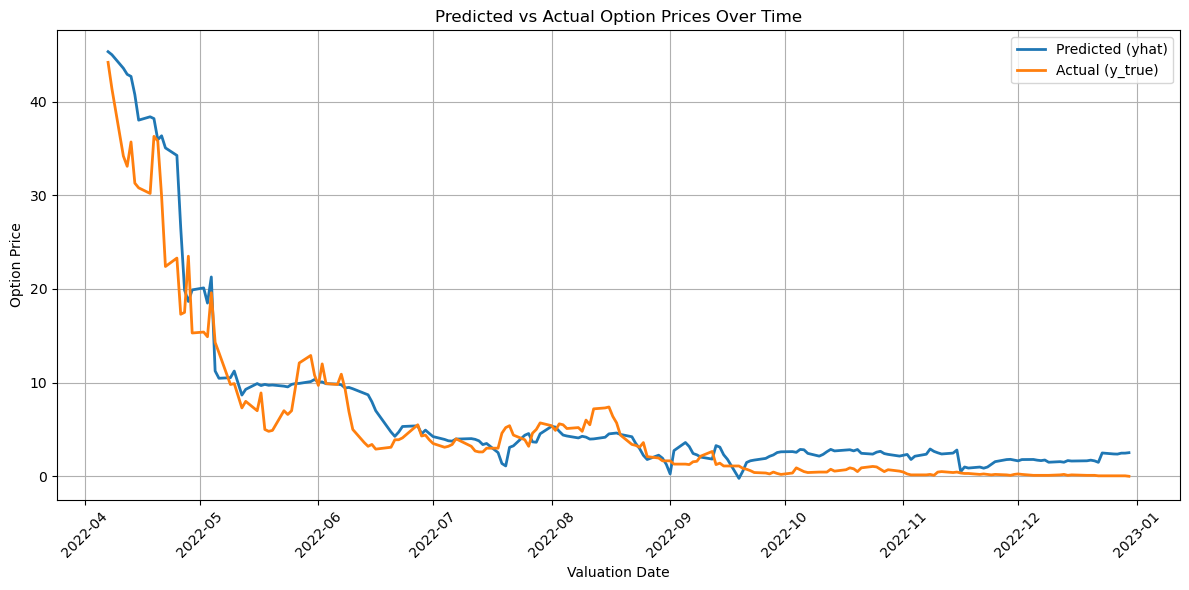

In [194]:
plotprices(pred_df_k1)

In [210]:
results = []
mse_strike = []

pred_df_all = pd.DataFrame()

mse, pred_df = train_and_predict_all(
    subset_800,
    model,
    date_col="QUOTE_DATE",
    features=["UNDERLYING_LAST", "STRIKE", "VOL_GG", "RFR", "DTE"],
    target_col="C_BID",     # ensure this exists for MSE
    type_col="call",        # e.g., "call"/"put"
    seq_len=5,
    batch_size=32,
    epochs=500,
    lr = 0.004469,
    weight_decay = 0.000425,
    grad_clip = 1.0,
    device = "cuda",
    verbose = True #False
)


pred_df.head()


epoch 001 | train MSE 0.013713
epoch 002 | train MSE 0.008912
epoch 003 | train MSE 0.036626
epoch 004 | train MSE 0.004953
epoch 005 | train MSE 0.003676
epoch 006 | train MSE 0.004709
epoch 007 | train MSE 0.001920
epoch 008 | train MSE 0.001979
epoch 009 | train MSE 0.001707
epoch 010 | train MSE 0.002047
epoch 011 | train MSE 0.001491
epoch 012 | train MSE 0.000988
epoch 013 | train MSE 0.000808
epoch 014 | train MSE 0.001333
epoch 015 | train MSE 0.001291
epoch 016 | train MSE 0.001072
epoch 017 | train MSE 0.000695
epoch 018 | train MSE 0.000626
epoch 019 | train MSE 0.000517
epoch 020 | train MSE 0.000592
epoch 021 | train MSE 0.000534
epoch 022 | train MSE 0.000935
epoch 023 | train MSE 0.000422
epoch 024 | train MSE 0.000673
epoch 025 | train MSE 0.000730
epoch 026 | train MSE 0.000911
epoch 027 | train MSE 0.000941
epoch 028 | train MSE 0.001171
epoch 029 | train MSE 0.000817
epoch 030 | train MSE 0.001050
epoch 031 | train MSE 0.002742
epoch 032 | train MSE 0.001226
epoch 03

,valuation_date,yhat,option_type,STRIKE,DTE,y_true
0,2022-04-07,3611.431152,call,800.0,344.0,3656.000000
1,2022-04-08,3609.842529,call,800.0,343.0,3644.500000
2,2022-04-11,3541.662354,call,800.0,340.0,3549.899902
3,2022-04-12,3512.752441,call,800.0,339.0,3535.500000
4,2022-04-13,3565.052002,call,800.0,338.0,3598.800049


In [211]:
pred_df.shape

(564, 6)

In [212]:
pred_df_k2 = pred_df[pred_df["STRIKE"] == 800.0]
pred_df_k4 = pred_df[pred_df["STRIKE"] == 4825.0]
pred_df_k1 = pred_df[pred_df["STRIKE"] == 5375.0]

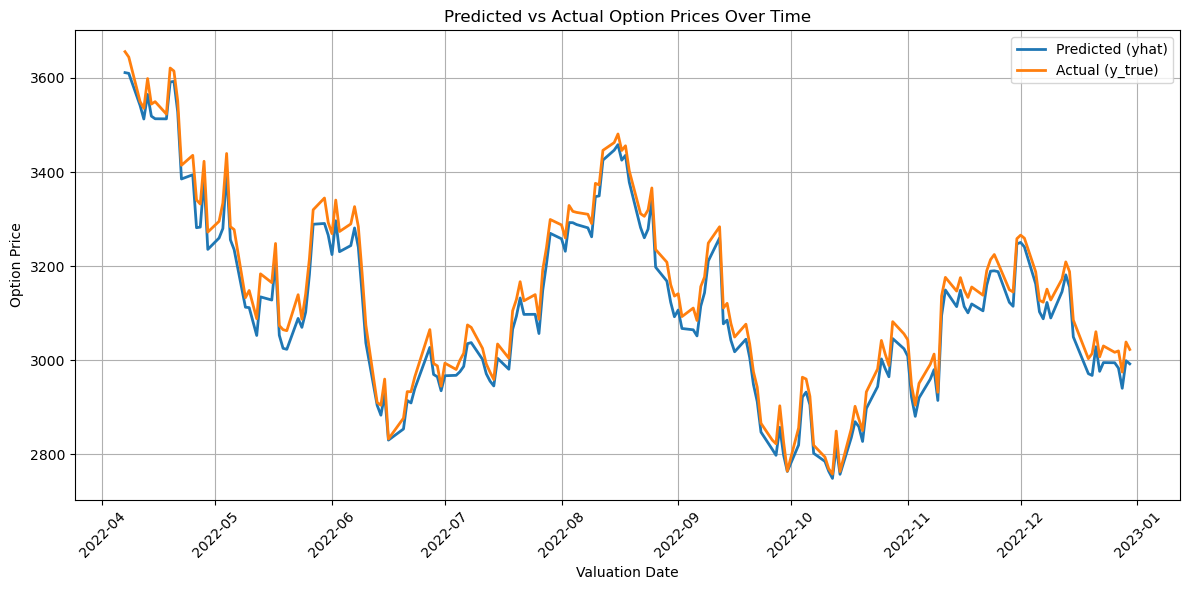

In [213]:
plotprices(pred_df_k2)

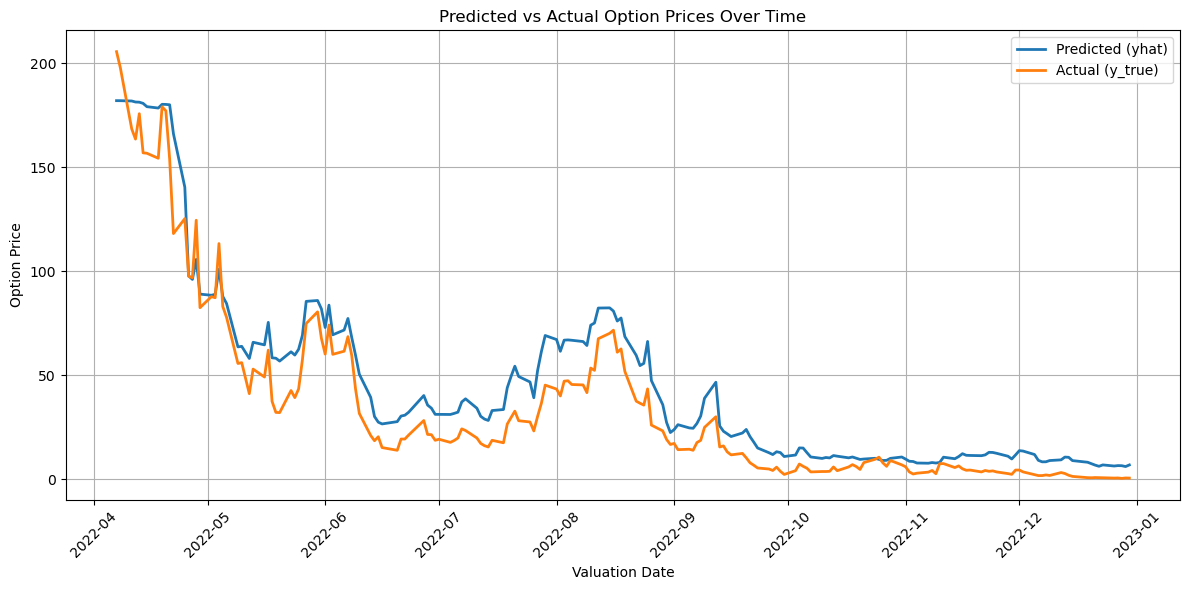

In [214]:
plotprices(pred_df_k4)

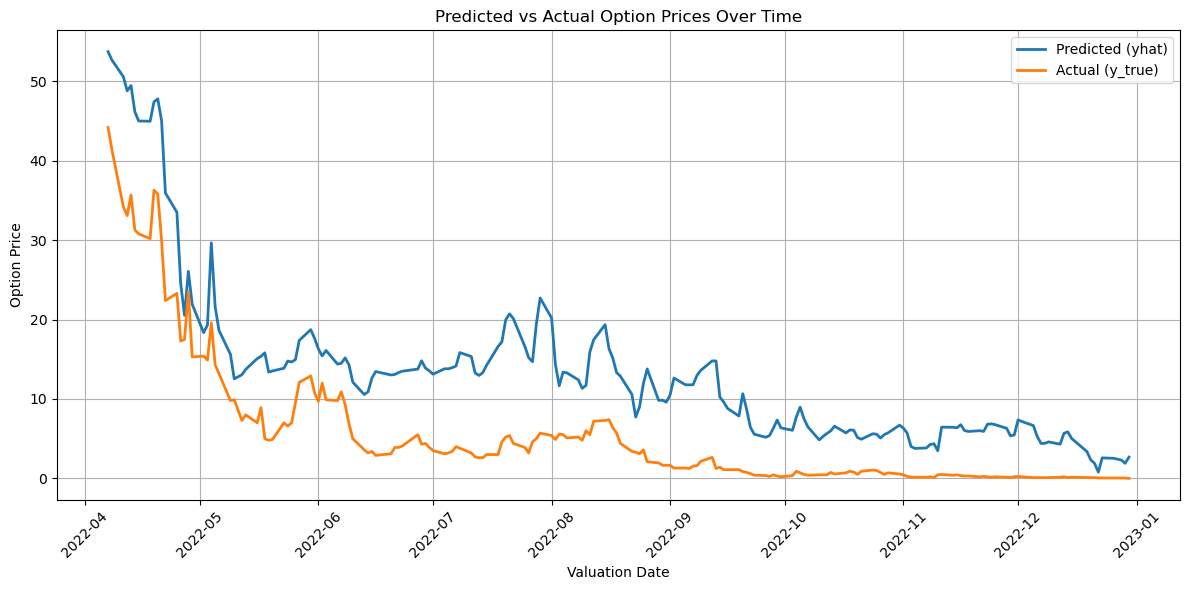

In [215]:
plotprices(pred_df_k1)

In [221]:
test_mse, pred_test = evaluate_on_test_all(
    subset_800_test,
    model,
    date_col="QUOTE_DATE",
    features=["UNDERLYING_LAST", "STRIKE", "VOL_GG", "RFR", "DTE"],
    target_col="C_BID",
    type_col="call",
    seq_len=5,
    batch_size=64,
)

print("Train MSE:", mse)
print("Test  MSE:", test_mse)
pred_test.head()

Train MSE: 421.54461669921875
Test  MSE: 198.1912384033203


,valuation_date,yhat,option_type,STRIKE,DTE,y_true
0,2023-01-10,3073.246094,call,800.0,65.959999,3111.100098
1,2023-01-11,3126.529053,call,800.0,64.959999,3160.000000
2,2023-01-12,3145.599609,call,800.0,63.959999,3174.800049
3,2023-01-13,3164.485840,call,800.0,62.959999,3191.500000
4,2023-01-17,3156.729248,call,800.0,58.959999,3183.199951


In [222]:
pred_test_k2 = pred_test[pred_test["STRIKE"] == 800.0]
pred_test_k4 = pred_test[pred_test["STRIKE"] == 4825.0]
pred_test_k1 = pred_test[pred_test["STRIKE"] == 5375.0]

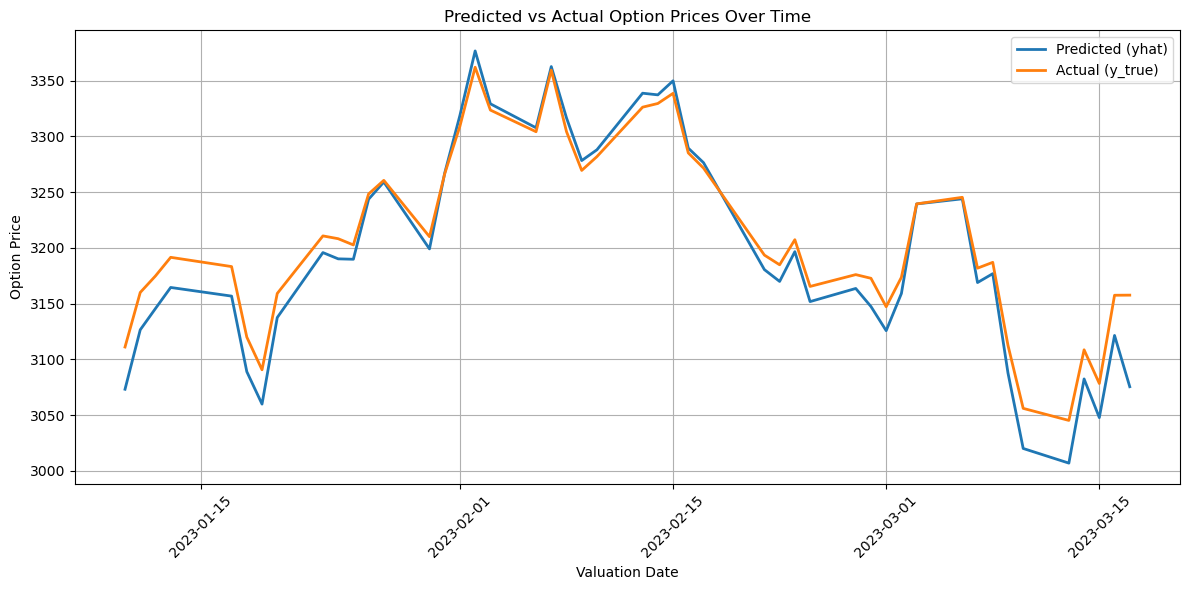

In [223]:
plotprices(pred_test_k2)

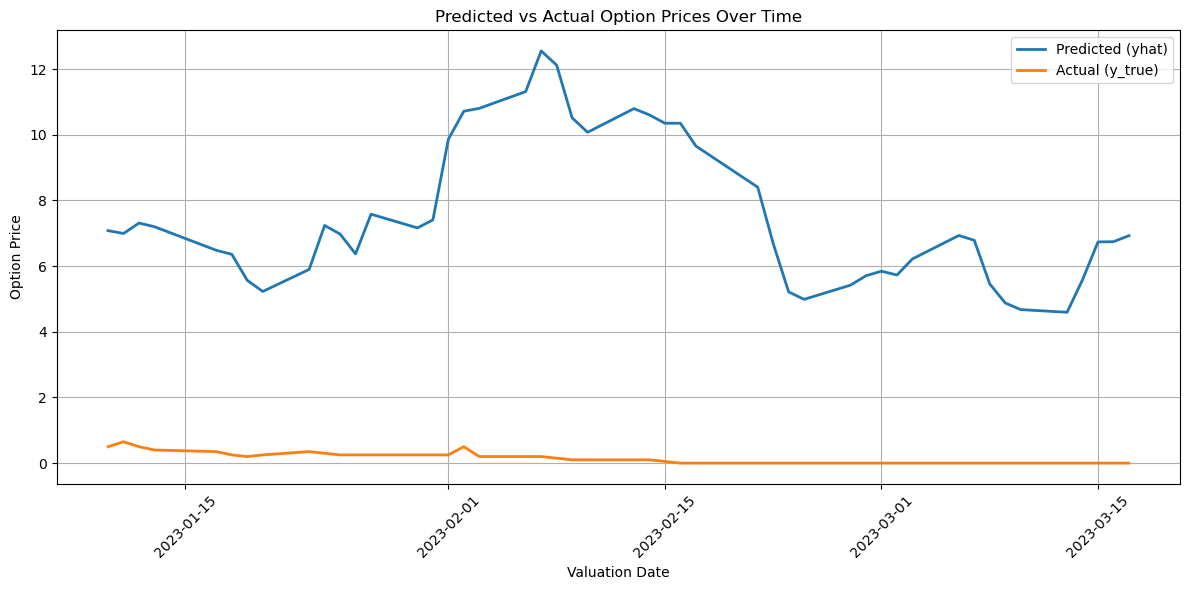

In [224]:
plotprices(pred_test_k4)

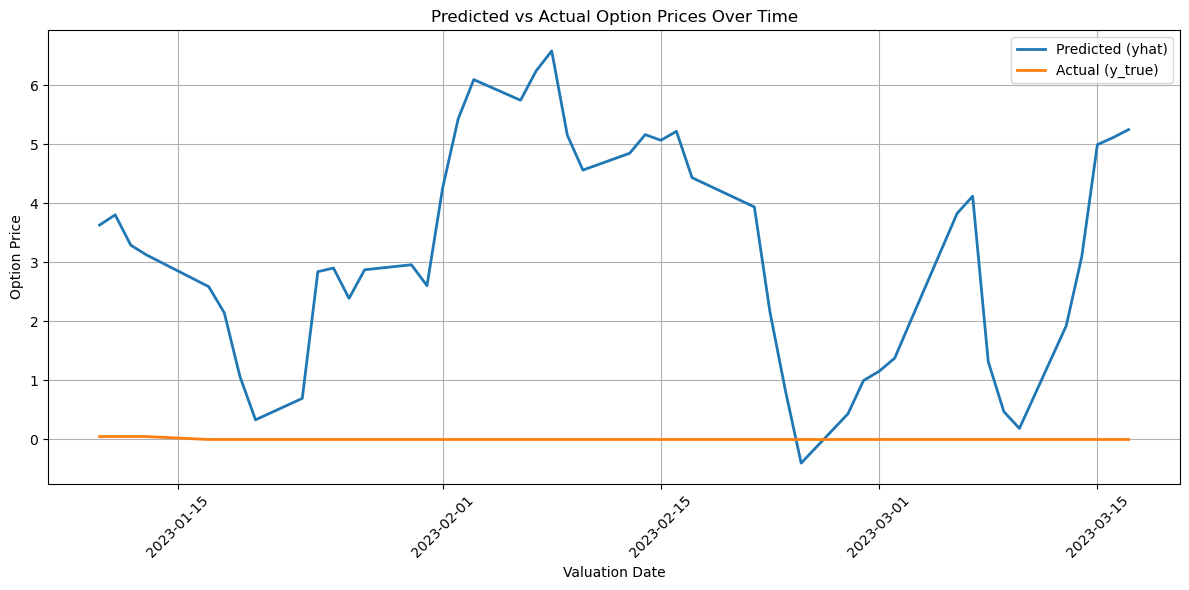

In [225]:
plotprices(pred_test_k1)